#**generating new images from the sample dataset**

This part of my project uses a **Variational Auto-Encoder (VAE)** to create new images that look like the ones from the FashionMNIST dataset, which has pictures of different fashion items. The main idea was to go beyond fixing old pictures and start making new, unique ones.

In simplified terms, VAE is like a smart artist that can take a picture, understand its essence, and then draw something new yet similar. It does this in three main steps:

1. **The Encoder**: Imagine you tell this artist about a dress, and they quickly sketch a simple outline or a blueprint. The encoder does something like this; it looks at an image and figures out the key features (like shape, style) and summarizes these into two key details: the mean (𝜇) and variance (𝜎²) of something called a latent variable (𝑧). The latent variable is a fancy term for the blueprint or essence of the image.

2. **The Reparameterization Block**: Now, the artist decides to add some personal touch to the sketch, making it unique. The reparametrization block takes the blueprint (mean and variance) and adds a bit of randomness (𝜖, which is like a random doodle) to it. This randomness is what makes each generated image unique, even if they start from the same blueprint.

3. **The Decoder**: Finally, the artist takes the unique sketch and fills in the details, colors, and textures, turning it back into a complete picture. The decoder takes the adjusted blueprint (the sample from the latent space) and recreates an image from it, attempting to make it as close to the original idea as possible.


##imports
to import necessary packages

In [2]:
import torch

import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets.mnist import FashionMNIST

##VAE model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, hidden_dim, latent_dim, class_emb_dim, num_classes=10):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.mu_net = nn.Linear(hidden_dim, latent_dim)

        self.logvar_net = nn.Linear(hidden_dim, latent_dim)

        self.class_embedding = nn.Embedding(num_classes, class_emb_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + class_emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor, y: torch.Tensor):
        x = x.view(x.size(0), -1)
        h = self.encoder(x)

        mu = self.mu_net(h)
        logvar = self.logvar_net(h)

        z = self.reparameterize(mu, logvar)

        class_emb = self.class_embedding(y)
        z = torch.cat([z, class_emb], dim=1)

        reconstructed = self.decoder(z)
        reconstructed = reconstructed.view(x.size())

        return reconstructed, mu, logvar

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def kl_loss(self, mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


    def get_loss(self, x: torch.Tensor, y: torch.Tensor):
        reconstructed, mu, logvar = self.forward(x, y)
        recons_loss = F.binary_cross_entropy(reconstructed, x.view(x.size(0), -1), reduction='sum')
        prior_loss = self.kl_loss(mu, logvar)
        return recons_loss, prior_loss

    @torch.no_grad()
    def generate_sample(self, num_images, y, device):
        latent_dim = self.mu_net.out_features
        class_emb_dim = self.class_embedding.embedding_dim

        z = torch.randn(num_images, latent_dim).to(device)
        if y is not None:
            class_emb = self.class_embedding(y).to(device)
            z = torch.cat([z, class_emb], dim=1)

        samples = self.decoder(z)
        samples = samples.view(num_images, 1, 28, 28)
        return samples

def load_vae_and_generate():
    device = torch.device('cuda')
    latent_dim = 20
    hidden_dim = 400
    class_emb_dim = 10
    vae = VAE(hidden_dim, latent_dim, class_emb_dim).to(device)


    vae.load_state_dict(torch.load('vae.pt', map_location=device))

    desired_labels = torch.tensor([i for i in range(10) for _ in range(5)]).to(device)
    generated_samples = vae.generate_sample(50, desired_labels, device)

    return generated_samples


##Loading the FashionMNSIT dataset

In [4]:
kwargs = {'root':'datasets/FashionMNIST',
          'train':True,
          'transform':transforms.ToTensor(),
          'download':True}

train_dataset = FashionMNIST(**kwargs)

train_dataset, val_dataset = random_split(train_dataset, [len(train_dataset) - 12000, 12000])

100%|██████████| 26421880/26421880 [00:02<00:00, 11802433.98it/s]


Extracting datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to datasets/FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 199998.84it/s]


Extracting datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to datasets/FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3752522.17it/s]


Extracting datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to datasets/FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5078146.05it/s]

Extracting datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/FashionMNIST/FashionMNIST/raw



48000 12000
(28, 28, 1)


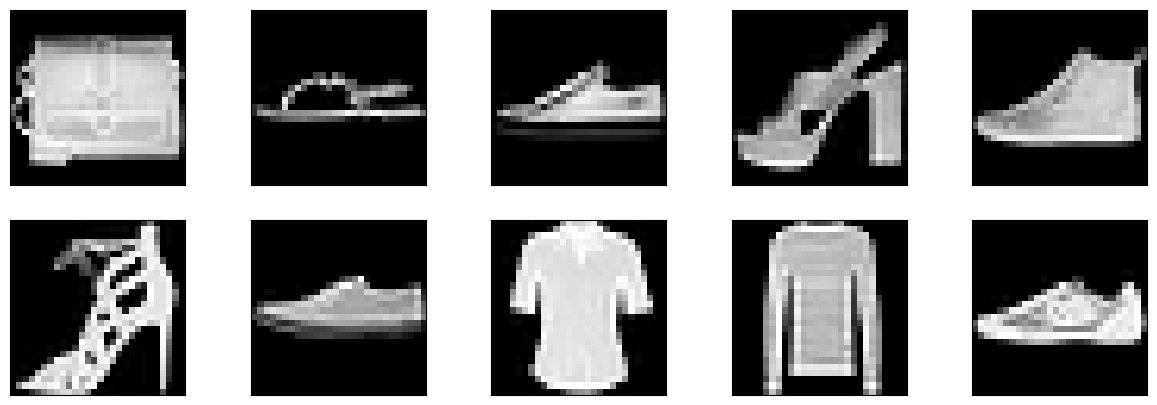

In [7]:
# showing the dataset
print(len(train_dataset), len(val_dataset))

sample_images = [train_dataset[i][0].permute(1, 2, 0).numpy() for i in range(10)]
print(sample_images[0].shape)
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(15, 5)
for i in range(2):
    for j in range(5):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].imshow(sample_images[i * 5 + j], cmap='gray')
plt.show()

##Training the model

In [8]:
def train(vae: VAE,
          train_loader: DataLoader,
          val_loader: DataLoader,
          optimizer: optim,
          epochs: int,
          reg_factor: float=1.,
          device=torch.device('cuda'),
          display_interval: int=5):

  itrs = tqdm(range(epochs))
  itrs.set_description(f'Train Recons Loss: ? - Train Prior Loss: ? (Total: ?)- '
                       f'Val Recons Loss: ? - Val Prior Loss: ? (Total: ?)')

  best_loss = float('inf')
  for epoch in itrs:
    avg_train_loss = 0.
    avg_prior_loss = 0.
    avg_recons_loss = 0.
    for sample in train_loader:
      x = sample[0].to(device)
      y = sample[1].type(torch.long).to(device)

      optimizer.zero_grad()

      recons_loss, prior_loss = vae.get_loss(x, y)

      loss = recons_loss + reg_factor * prior_loss

      avg_prior_loss += prior_loss.item()
      avg_recons_loss += recons_loss.item()
      avg_train_loss += loss.item()

      loss.backward()
      optimizer.step()

    avg_recons_loss /= len(train_loader)
    avg_prior_loss /= len(train_loader)
    avg_train_loss /= len(train_loader)

    with torch.no_grad():
      avg_val_loss = 0.
      avg_val_prior_loss = 0.
      avg_val_recons_loss = 0.
      for sample in val_loader:
        x = sample[0].to(device)
        y = sample[1].type(torch.long).to(device)

        recons_loss, prior_loss = vae.get_loss(x, y)

        loss = recons_loss + reg_factor * prior_loss

        avg_val_prior_loss += prior_loss.item()
        avg_val_recons_loss += recons_loss.item()
        avg_val_loss += loss.item()

      avg_val_prior_loss /= len(val_loader)
      avg_val_recons_loss /= len(val_loader)
      avg_val_loss /= len(val_loader)

    itrs.set_description(f'Train Recons Loss: {avg_recons_loss:.3f} - Train Prior Loss: {avg_prior_loss:.3f} (Total: {avg_train_loss:.3f})- '
                         f'Val Recons Loss: {avg_val_recons_loss:.3f} - Val Prior Loss: {avg_val_prior_loss:.3f} (Total: {avg_val_loss:.3f})')

    # save the model on the best validation loss
    if best_loss > avg_val_loss:
      best_loss = avg_val_loss
      torch.save(vae.state_dict(), 'vae.pt')

    if display_interval is not None:
      if epoch % display_interval == 0 or epoch == epochs - 1:
        # generate some sample to see the quality of the generative model
        samples = vae.generate_sample(10, torch.arange(10).cuda(), torch.device('cuda'))
        fig, ax = plt.subplots(1, 10)
        fig.set_size_inches(15, 10)
        for i in range(10):
          ax[i].set_xticks([])
          ax[i].set_yticks([])
          ax[i].imshow(samples[i].cpu().permute(1, 2, 0).numpy(), cmap='gray')
        plt.show()

Train Recons Loss: 17355.905 - Train Prior Loss: 317.986 (Total: 17673.891)- Val Recons Loss: 16509.286 - Val Prior Loss: 311.671 (Total: 16820.957):   0%|          | 0/10 [00:10<?, ?it/s]

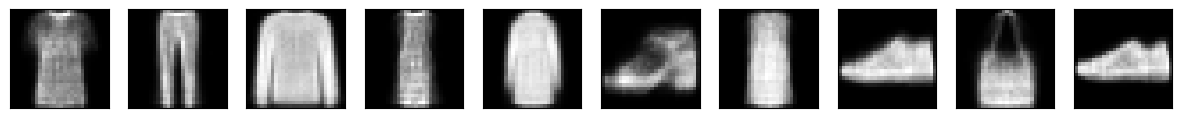

Train Recons Loss: 16278.403 - Train Prior Loss: 314.979 (Total: 16593.382)- Val Recons Loss: 16274.067 - Val Prior Loss: 297.456 (Total: 16571.523):  50%|█████     | 5/10 [00:56<00:46,  9.39s/it]

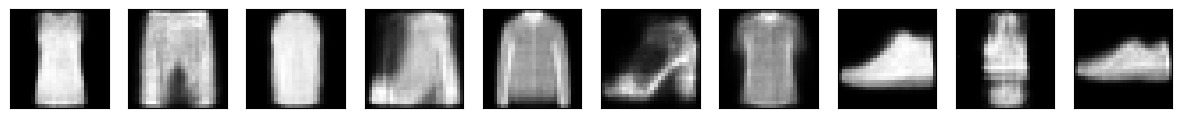

Train Recons Loss: 16229.847 - Train Prior Loss: 319.532 (Total: 16549.379)- Val Recons Loss: 16216.101 - Val Prior Loss: 313.594 (Total: 16529.695):  90%|█████████ | 9/10 [01:33<00:09,  9.29s/it]

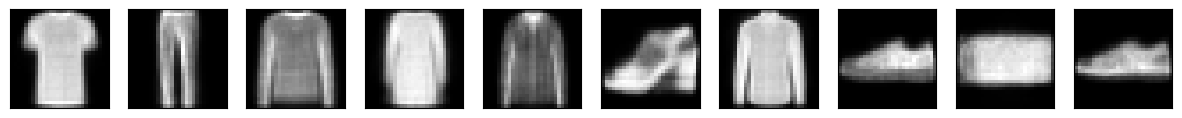

Train Recons Loss: 16229.847 - Train Prior Loss: 319.532 (Total: 16549.379)- Val Recons Loss: 16216.101 - Val Prior Loss: 313.594 (Total: 16529.695): 100%|██████████| 10/10 [01:34<00:00,  9.41s/it]


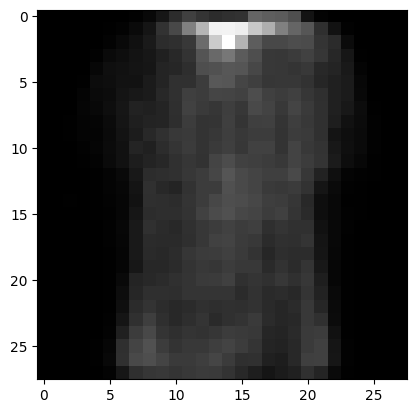

In [9]:
device = torch.device('cuda')
batch_size = 64
vae = VAE(hidden_dim=400, latent_dim=10, class_emb_dim=10, num_classes=10)
lr = 0.01
optimizer = optim.Adam(vae.parameters(), lr=lr, amsgrad=True)
reg_factor = 1
epochs = 10

display_interval = 5

# defining the dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# moving the model to gpu
vae = vae.to(device)

# training the model
train(vae=vae,
      train_loader=train_loader,
      val_loader=val_loader,
      optimizer=optimizer,
      epochs=epochs,
      reg_factor=reg_factor,
      device=device,
      display_interval=display_interval)

generated_sample = vae.generate_sample(1, torch.tensor([0]).cuda(), device)

plt.imshow(generated_sample[0].squeeze(0).cpu().numpy(), cmap='gray')
plt.show()

##final implementation

In [10]:
# a classifier trained on FashionMNIST (DO NOT CHANGE THE CODE BELOW)
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64*7*7, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

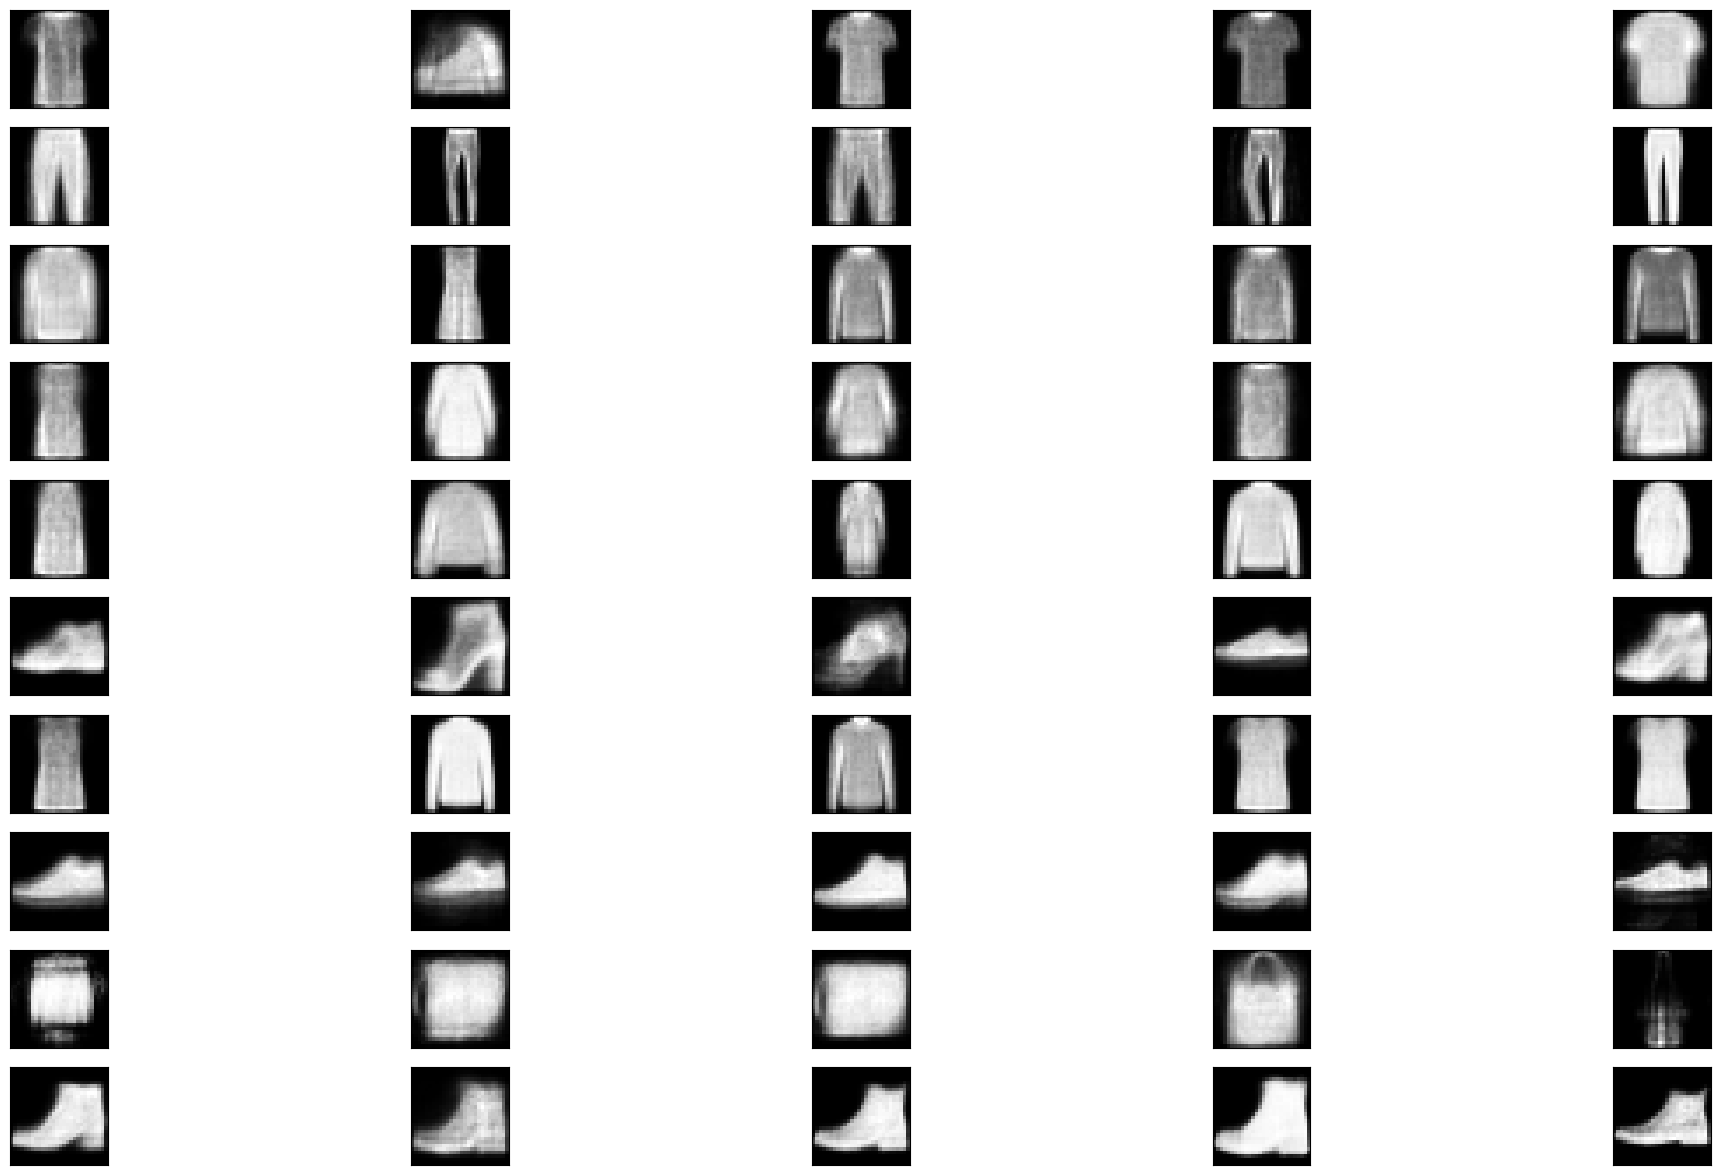

tensor([0, 9, 0, 0, 0, 1, 1, 1, 1, 1, 2, 3, 2, 3, 2, 3, 3, 3, 3, 8, 6, 4, 4, 4,
        4, 9, 9, 9, 7, 9, 3, 6, 6, 6, 6, 7, 7, 7, 9, 7, 6, 8, 8, 8, 3, 9, 9, 9,
        9, 9], device='cuda:0')
72.00


In [19]:
# here we use the classifier to see if how well it can classify the generated images (do not change the following code)
# generate 5 samples from each class
desired_labels = []
for i in range(10):
    for _ in range(5):
        desired_labels.append(i)

desired_labels = torch.tensor(desired_labels).cuda()

# load your vae
vae.load_state_dict(torch.load('vae.pt'))
vae = vae.to(device)

# generate samples from the VAE
generated_samples = vae.generate_sample(50, desired_labels, torch.device('cuda'))

fig, ax = plt.subplots(10, 5)
fig.set_size_inches(25, 15)
for i in range(10):
    for j in range(5):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].imshow(generated_samples[i * 5 + j].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.show()

classifier = Classifier().to(device)
classifier.load_state_dict(torch.load('classifier.pt'))

with torch.no_grad():
    preds = classifier(generated_samples)

preds = torch.argmax(preds, dim=-1)
acc = (preds == desired_labels).sum() / 50.

print(preds)
print(f'{acc.cpu().item() * 100:.2f}')